In [1]:
from numpy import sin, cos
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
from IPython.display import HTML
import random

%matplotlib inline

https://matplotlib.org/examples/animation/double_pendulum_animated.html

In [2]:
def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*cos(del_)*cos(del_)
    dydx[1] = (M2*L1*state[1]*state[1]*sin(del_)*cos(del_) +
               M2*G*sin(state[2])*cos(del_) +
               M2*L2*state[3]*state[3]*sin(del_) -
               (M1 + M2)*G*sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*sin(del_)*cos(del_) +
               (M1 + M2)*G*sin(state[0])*cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*sin(del_) -
               (M1 + M2)*G*sin(state[2]))/den2

    return dydx

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

def generate_state():
    return np.random.uniform(-1, 1, 4) * np.array([th1_max, w1_max, th2_max, w2_max])

In [3]:
G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 0.5  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 0.3  # mass of pendulum 2 in kg

# simulation time
dt = 0.05
timestep = 100

# Create input ranges
th1_max = np.radians(100)
w1_max = np.radians(100)
th2_max = np.radians(360)
w2_max = np.radians(360)

# create a time array from 0..100 sampled at dt second steps
t = np.arange(dt, (timestep+1)*dt, dt)

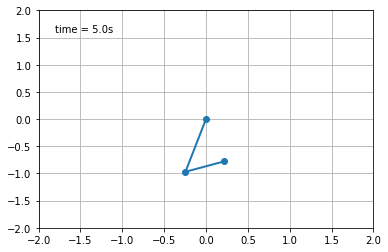

In [4]:
state = generate_state()

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

# # rendering
x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])

x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

anim = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=1000*dt, blit=True, init_func=init)

# anim.save('double_pendulum.mp4', fps=15)
HTML(anim.to_html5_video())

# Create Dataset

In [5]:
def simulate(state):
    y = integrate.odeint(derivs, state, t)
    return y

In [6]:
sample_size = 25000

X = np.zeros(shape=(sample_size, timestep, 4))
Y = np.zeros(shape=(sample_size, timestep, 4))

for i in range(sample_size):
    if i % 1000 == 0:
        print(i)
    init_state = generate_state()
    y = simulate(init_state)
    X[i] = y[:-1]
    Y[i] = y[1:]
    
np.save("X3.npy", X)
np.save("y3.npy", Y)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


# Create Model

In [46]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, CuDNNLSTM
from keras.models import load_model
from keras.regularizers import l1, l2

In [8]:
X = np.load("X3.npy")
Y = np.load("y3.npy")

In [9]:
X = X/np.array([th1_max, w1_max, th2_max, w2_max])
Y = Y/np.array([th1_max, w1_max, th2_max, w2_max])

In [10]:
# activation = "tanh"
# recurrent_activation = "hard_sigmoid"

In [82]:
model = Sequential()
model.add(CuDNNLSTM(128, 
            return_sequences=True, 
            input_shape=(timestep, 4),
            kernel_regularizer=l1(0.001),
         ))
model.add(CuDNNLSTM(128, 
            return_sequences=True,
            kernel_regularizer=l1(0.001),  
         ))
# model.add(CuDNNLSTM(128, 
#             return_sequences=True,
#             kernel_regularizer=l1(0.001),
#          ))
# model.add(CuDNNLSTM(32, 
#             return_sequences=True,
#             kernel_regularizer=l1(0.001),
#          ))
# model.add(Dense(32))
model.add(Dense(4))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_51 (CuDNNLSTM)    (None, 100, 128)          68608     
_________________________________________________________________
cu_dnnlstm_52 (CuDNNLSTM)    (None, 100, 128)          132096    
_________________________________________________________________
dense_23 (Dense)             (None, 100, 4)            516       
Total params: 201,220
Trainable params: 201,220
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile(loss='mean_squared_error',
              optimizer='Nadam',
              # metrics=["mean_squared_error" , 'mean_absolute_percentage_error']
             ) 

In [93]:
model.fit(X, Y,
          epochs=50,
          batch_size=256,
          validation_split=0.2,
          verbose=2
         )

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
 - 2s - loss: 0.0381 - val_loss: 0.0382
Epoch 2/50
 - 2s - loss: 0.0372 - val_loss: 0.0374
Epoch 3/50
 - 2s - loss: 0.0371 - val_loss: 0.0359
Epoch 4/50
 - 2s - loss: 0.0368 - val_loss: 0.0366
Epoch 5/50
 - 2s - loss: 0.0363 - val_loss: 0.0355
Epoch 6/50
 - 2s - loss: 0.0360 - val_loss: 0.0382
Epoch 7/50
 - 2s - loss: 0.0358 - val_loss: 0.0364
Epoch 8/50
 - 2s - loss: 0.0358 - val_loss: 0.0354
Epoch 9/50
 - 2s - loss: 0.0352 - val_loss: 0.0345
Epoch 10/50
 - 2s - loss: 0.0350 - val_loss: 0.0340
Epoch 11/50
 - 2s - loss: 0.0345 - val_loss: 0.0341
Epoch 12/50
 - 2s - loss: 0.0350 - val_loss: 0.0361
Epoch 13/50
 - 2s - loss: 0.0339 - val_loss: 0.0330
Epoch 14/50
 - 2s - loss: 0.0337 - val_loss: 0.0339
Epoch 15/50
 - 2s - loss: 0.0336 - val_loss: 0.0326
Epoch 16/50
 - 2s - loss: 0.0332 - val_loss: 0.0330
Epoch 17/50
 - 2s - loss: 0.0332 - val_loss: 0.0325
Epoch 18/50
 - 2s - loss: 0.0327 - val_loss: 0.0326
Epoch 19/50
 - 2s - loss

In [94]:
model.save("model.h5")

# Generator

In [95]:
newModel = Sequential()
newModel.add(CuDNNLSTM(128, 
                 stateful=True, 
                 return_sequences=True, 
                 batch_input_shape=(1, 1, 4),
            ))
newModel.add(CuDNNLSTM(128, 
                 stateful=True, 
                 return_sequences=True,
            ))
# newModel.add(CuDNNLSTM(128, 
#                  stateful=True, 
#                  return_sequences=True,
#             ))
# newModel.add(CuDNNLSTM(32, 
#             stateful=True, 
#             return_sequences=True,
#          ))
# newModel.add(Dense(32))
newModel.add(Dense(4))

try:
    weight = model.get_weights()
except:
    model = load_model('model.h5')
    weight = model.get_weights()
newModel.set_weights(weight)

newModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_55 (CuDNNLSTM)    (1, 1, 128)               68608     
_________________________________________________________________
cu_dnnlstm_56 (CuDNNLSTM)    (1, 1, 128)               132096    
_________________________________________________________________
dense_25 (Dense)             (1, 1, 4)                 516       
Total params: 201,220
Trainable params: 201,220
Non-trainable params: 0
_________________________________________________________________


In [96]:
newModel.reset_states()

init_state = generate_state()
simulation = simulate(init_state)

prediction = []
state = np.expand_dims(init_state, 0)
state = np.expand_dims(state, 0)
state = state/np.array([th1_max, w1_max, th2_max, w2_max])
for i in range(timestep+1):
    state = newModel.predict(state)
    prediction.append(state[0, 0, :])
    
prediction = np.array(prediction)
prediction = prediction * np.array([th1_max, w1_max, th2_max, w2_max])

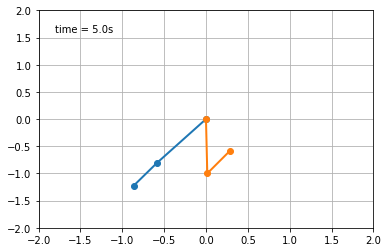

In [97]:
def init():
    line.set_data([], [])
    line2.set_data([], [])
    time_text.set_text('')
    return line, line2, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]
    
    thisx2 = [0, x3[i], x4[i]]
    thisy2 = [0, y3[i], y4[i]]

    line.set_data(thisx, thisy)
    line2.set_data(thisx2, thisy2)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

x1 = L1*sin(simulation[:, 0])
y1 = -L1*cos(simulation[:, 0])

x2 = L2*sin(simulation[:, 2]) + x1
y2 = -L2*cos(simulation[:, 2]) + y1

x3 = L1*sin(prediction[:, 0])
y3 = -L1*cos(prediction[:, 0])

x4 = L2*sin(prediction[:, 2]) + x3
y4 = -L2*cos(prediction[:, 2]) + y3

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y1)),
                              interval=1000*dt, blit=True, init_func=init)

# ani.save('double_pendulum.mp4', fps=15)
HTML(ani.to_html5_video())